# IoT Air Quality - Procesamiento con PySpark en Colab
Implementación de análisis exploratorio, limpieza de datos y modelo predictivo con PySpark en Google Colab.

Por: Santiago Saldarriaga Saldarriaga

In [ ]:
# Instalación de Java, Spark y findspark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, max, stddev, count
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Crear sesión de Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("IoT_AirQuality_Colab") \
    .getOrCreate()

In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Maestria_Ccia_Datos_y_Analitica/proyecto1db/raw/


iot_airquality_colab_pyspark.ipynb


In [ ]:
# Leer el dataset desde Drive
file_path = "drive/MyDrive/Maestria_Ccia_Datos_y_Analitica/proyecto1db/raw/IoT_Indoor_Air_Quality_Dataset.csv"
df_raw = spark.read.option("header", True).option("inferSchema", True).csv(file_path)
df_raw.show(5)

+----------------+----------------+------------+---------+-------------+------------+----------+--------+---------------------+---------------+---------------+------------------+
|       Timestamp|Temperature (?C)|Humidity (%)|CO2 (ppm)|PM2.5 (?g/m?)|PM10 (?g/m?)|TVOC (ppb)|CO (ppm)|Light Intensity (lux)|Motion Detected|Occupancy Count|Ventilation Status|
+----------------+----------------+------------+---------+-------------+------------+----------+--------+---------------------+---------------+---------------+------------------+
|18-02-2024 08:00|           21.75|       63.11|   989.74|        31.17|       89.66|    226.83|    2.84|               646.86|              0|             49|              Open|
|18-02-2024 08:05|           27.51|       68.03|   924.59|        27.32|       44.82|    116.76|    3.12|               845.45|              1|             11|              Open|
|18-02-2024 08:10|           25.32|       53.51|   604.05|        73.84|       71.08|     56.59|    3.59|

In [ ]:
# Limpieza básica de columnas y transformación
import re
from pyspark.sql.functions import col, to_timestamp

# Limpiar nombres de columnas y pasarlas a minúsculas
new_columns = []
for c in df_raw.columns:
    clean_name = re.sub(r'[^a-zA-Z0-9_]', '_', c)
    clean_name = re.sub(r'__+', '_', clean_name).lower()
    new_columns.append((c, clean_name))

for old, new in new_columns:
    df_raw = df_raw.withColumnRenamed(old, new)

df_clean = df_raw.dropna().dropDuplicates()
df_clean = df_clean.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))
df_clean.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- temperature_c_: double (nullable = true)
 |-- humidity_: double (nullable = true)
 |-- co2_ppm_: double (nullable = true)
 |-- pm2_5_g_m_: double (nullable = true)
 |-- pm10_g_m_: double (nullable = true)
 |-- tvoc_ppb_: double (nullable = true)
 |-- co_ppm_: double (nullable = true)
 |-- light_intensity_lux_: double (nullable = true)
 |-- motion_detected: integer (nullable = true)
 |-- occupancy_count: integer (nullable = true)
 |-- ventilation_status: string (nullable = true)



In [ ]:
# EDA agrupado por estado de ventilación
from pyspark.sql.functions import avg, max, stddev, count
eda_df = df_clean.groupBy("ventilation_status").agg(
    count("*").alias("total_registros"),
    avg("temperature_c_").alias("temp_promedio"),
    avg("humidity_").alias("humedad_promedio"),
    avg("co2_ppm_").alias("co2_promedio"),
    max("pm2_5_g_m_").alias("pm2_5_max"),
    stddev("co_ppm_").alias("stddev_co")
)
eda_df.show()

+------------------+---------------+-----------------+-----------------+-----------------+---------+------------------+
|ventilation_status|total_registros|    temp_promedio| humedad_promedio|     co2_promedio|pm2_5_max|         stddev_co|
+------------------+---------------+-----------------+-----------------+-----------------+---------+------------------+
|              Open|          38892|22.98837113030965|49.98426000205701|700.8893008845029|     75.0|1.4130626696149913|
|            Closed|          39105|22.99419306993993|50.06404756425013|700.4026423730992|     75.0|1.4151698981300382|
+------------------+---------------+-----------------+-----------------+-----------------+---------+------------------+



In [ ]:
# Modelo de clasificación binaria
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import when

df_model = df_clean.withColumn("label", when(col("ventilation_status") == "On", 1).otherwise(0))
feature_cols = [
    "temperature_c_", "humidity_", "co2_ppm_", "pm2_5_g_m_", "pm10_g_m_",
    "tvoc_ppb_", "co_ppm_", "light_intensity_lux_", "motion_detected", "occupancy_count"
]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
rf = RandomForestClassifier(featuresCol="features", labelCol="label", predictionCol="prediction")
pipeline = Pipeline(stages=[assembler, rf])
model = pipeline.fit(df_model)
predictions = model.transform(df_model)
predictions.select("timestamp", "ventilation_status", "prediction", "probability").show(5)

+---------+------------------+----------+-----------+
|timestamp|ventilation_status|prediction|probability|
+---------+------------------+----------+-----------+
|     null|            Closed|       0.0|      [1.0]|
|     null|            Closed|       0.0|      [1.0]|
|     null|            Closed|       0.0|      [1.0]|
|     null|            Closed|       0.0|      [1.0]|
|     null|              Open|       0.0|      [1.0]|
+---------+------------------+----------+-----------+
only showing top 5 rows



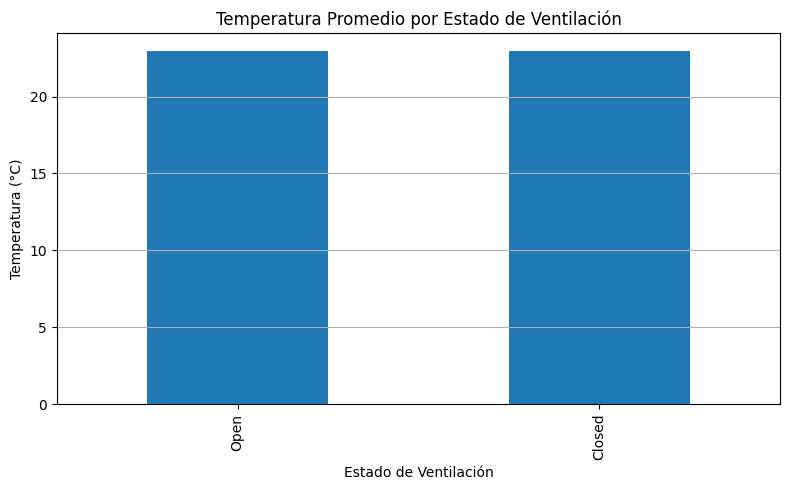

In [ ]:
# Convertir a Pandas para graficar
eda_pd = eda_df.toPandas()
eda_pd.set_index("ventilation_status", inplace=True)

# Gráfico: Temperatura promedio por estado de ventilación
plt.figure(figsize=(8, 5))
eda_pd["temp_promedio"].plot(kind="bar", title="Temperatura Promedio por Estado de Ventilación")
plt.ylabel("Temperatura (°C)")
plt.xlabel("Estado de Ventilación")
plt.grid(axis='y')
plt.tight_layout()
plt.show()